In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.optimize import curve_fit
import ROOT as rt
import glob
import uproot
from root_numpy import array2hist

import boosted_fits as bsvj

import itertools, re, logging, os, os.path as osp, copy, subprocess, json

Welcome to JupyROOT 6.22/09


In [4]:
sc = rt.TFile('scans_20241120/higgsCombineObserveddc_SVJ_s-channel_mMed-500_mDark-10_rinv-0p3_alpha-peak_MADPT300_13TeV-madgraphMLM-pythia8_sel-cutbased_smoothScan.MultiDimFit.mH120.123456.root')
ws_sc = sc.Get('w')
pdf_ua2 = ws_sc.pdf('bsvj_bkgfitua2mod_npars3_rpsbp')
pdf_main = ws_sc.pdf('bsvj_bkgfitmain_npars2_rpsbp')
bkg_mc = ws_sc.data('data_obs') # data structure is RooDataSet
#sig_mc = ws_sc.data('sig') # systematics are not included in sig; data structure is RooAbsData
mt = ws_sc.var('mt')

mt_binning = bsvj.binning_from_roorealvar(mt)
mt_bin_centers = .5*(mt_binning[1:]+mt_binning[:-1])

In [5]:
# taking pdf of the two main and ua2mod functions
# plot them on top of each other
# purpose: bias test see if the two functions are actually different from each other

frame = mt.frame()
norm = rt.RooRealVar("norm", "normalization", bkg_mc.sumEntries())
normalization = rt.RooFit.Normalization(bkg_mc.sumEntries(), rt.RooAbsReal.NumEvent)

pdf_ua2.fitTo(bkg_mc)
pdf_main.fitTo(bkg_mc)

pdf_ua2.plotOn(frame, normalization, rt.RooFit.LineColor(rt.kBlue),rt.RooFit.Name('ua2mod'))
pdf_main.plotOn(frame, normalization, rt.RooFit.LineColor(rt.kRed),rt.RooFit.Name('main'))
bkg_mc.plotOn(frame,rt.RooFit.DataError(rt.RooAbsData.Poisson))

legend = rt.TLegend(0.7, 0.7, 0.9, 0.9)
legend.AddEntry(frame.findObject("ua2mod"), "ua2mod", "l")
legend.AddEntry(frame.findObject("main"), "main", "l")
legend.AddEntry(frame.findObject("bkg"), "bkg_mc", "P")
canv = rt.TCanvas("canv", "canv", 800, 600)
frame.Draw()
legend.Draw()
canv.SetLogy()
canv.SaveAs("checks/fitUA2modMainBkgMC_log.png")

[#0] WARNING:InputArguments -- RooAbsPdf::fitTo(bsvj_bkgfitua2mod_npars3_rpsbp) WARNING: a likelihood fit is requested of what appears to be weighted data.
       While the estimated values of the parameters will always be calculated taking the weights into account,
       there are multiple ways to estimate the errors of the parameters. You are advised to make an 
       explicit choice for the error calculation:
           - Either provide SumW2Error(true), to calculate a sum-of-weights-corrected HESSE error matrix
             (error will be proportional to the number of events in MC).
           - Or provide SumW2Error(false), to return errors from original HESSE error matrix
             (which will be proportional to the sum of the weights, i.e., a dataset with <sum of weights> events).
           - Or provide AsymptoticError(true), to use the asymptotically correct expression
             (for details see https://arxiv.org/abs/1911.01303).
[#1] INFO:NumericIntegration -- RooReal

Error in <ROOT::Math::Fitter::SetFCN>: FCN function has zero parameters 
Info in <TCanvas::Print>: png file checks/fitUA2modMainBkgMC_log.png has been created


In [4]:
# prefit
ws_sc = sc.Get('w')
mu_prefit = ws_sc.var('r').getVal() # at this point signal strength is zero (prefit)
bkg_sc = ws_sc.pdf('shapeBkg_roomultipdf_bsvj')
ybkg_sc = bsvj.pdf_values(bkg_sc, mt_bin_centers)
bkg_norm_sc = ws_sc.function('n_exp_final_binbsvj_proc_roomultipdf').getVal()
ybkg_sc *= bkg_norm_sc


# to get signal array with systematics and without additional signal strength factor
# at this point signal strength is zero (prefit)
ws_sc.var('r').setVal(1.0)
sig_sc = ws_sc.pdf('shapeSig_bsvj_sig_morph')
sig_norm_sc = ws_sc.function('n_exp_binbsvj_proc_sig').getVal()


ysig_sc = sig_norm_sc * bsvj.pdf_values(sig_sc, mt_bin_centers)
ws_sc.var('r').setVal(mu_prefit)

[#1] INFO:NumericIntegration -- RooRealIntegral::init(bsvj_bkgfitua2mod_npars3_rgp_Int[mt|bsvj_bkgfitua2mod_npars3_rpsbp_x_range_bin0]) using numeric integrator RooIntegrator1D to calculate Int(mt)
[#1] INFO:NumericIntegration -- RooRealIntegral::init(bsvj_bkgfitua2mod_npars3_rgp_Int[mt|bsvj_bkgfitua2mod_npars3_rpsbp_x_range_bin1]) using numeric integrator RooIntegrator1D to calculate Int(mt)
[#1] INFO:NumericIntegration -- RooRealIntegral::init(bsvj_bkgfitua2mod_npars3_rgp_Int[mt|bsvj_bkgfitua2mod_npars3_rpsbp_x_range_bin2]) using numeric integrator RooIntegrator1D to calculate Int(mt)
[#1] INFO:NumericIntegration -- RooRealIntegral::init(bsvj_bkgfitua2mod_npars3_rgp_Int[mt|bsvj_bkgfitua2mod_npars3_rpsbp_x_range_bin3]) using numeric integrator RooIntegrator1D to calculate Int(mt)
[#1] INFO:NumericIntegration -- RooRealIntegral::init(bsvj_bkgfitua2mod_npars3_rgp_Int[mt|bsvj_bkgfitua2mod_npars3_rpsbp_x_range_bin4]) using numeric integrator RooIntegrator1D to calculate Int(mt)
[#1] INFO:

In [6]:
# just a check, nothing finalized
# this block changes the signal normalization by setting the r value  


ws_sc = sc.Get('w')
ws_sc.var('r').setVal(1.0)
sig_sc = ws_sc.pdf('shapeSig_bsvj_sig_morph')
SC = bsvj.pdf_values(sig_sc, mt_bin_centers)
sig_norm_sc = ws_sc.function('n_exp_binbsvj_proc_sig').getVal()
SC*=sig_norm_sc


ws_sc.loadSnapshot('MultiDimFit')
ws_sc.var('r').getVal()
sig_ss = ws_sc.pdf('shapeSig_bsvj_sig_morph')
SS = bsvj.pdf_values(sig_ss, mt_bin_centers)
sig_norm_ss = ws_sc.function('n_exp_final_binbsvj_proc_sig').getVal()
SS*=sig_norm_ss


mu= 0.0
    bsvj_bkgfitua2mod_npars3_p1 = -15.003827235363602 +/- 0.25162281677717857
    bsvj_bkgfitua2mod_npars3_p2 = 14.33994502393054 +/- 0.7387042214986366
    bsvj_bkgfitua2mod_npars3_p3 = -14.436640055600137 +/- 0.6753866976383804
mu= 0.1
    bsvj_bkgfitua2mod_npars3_p1 = -14.065612833918593 +/- 0.2495083139056078
    bsvj_bkgfitua2mod_npars3_p2 = 11.920118715413096 +/- 0.7318878969309068
    bsvj_bkgfitua2mod_npars3_p3 = -12.406268521082936 +/- 0.6685806447724971
mu= 0.11
    bsvj_bkgfitua2mod_npars3_p1 = -13.168748899308596 +/- 0.24782861192437622
    bsvj_bkgfitua2mod_npars3_p2 = 9.63567687631597 +/- 0.7263394175000997
    bsvj_bkgfitua2mod_npars3_p3 = -10.50244143769686 +/- 0.6629377078382248
mu= 0.12
    bsvj_bkgfitua2mod_npars3_p1 = -12.313053951414176 +/- 0.24773220832820897
    bsvj_bkgfitua2mod_npars3_p2 = 7.48572314059912 +/- 0.7254504342114885
    bsvj_bkgfitua2mod_npars3_p3 = -8.724376647574346 +/- 0.6615321598595045
mu= 0.13
    bsvj_bkgfitua2mod_npars3_p1 = -11.497

(0.6, 1.4)

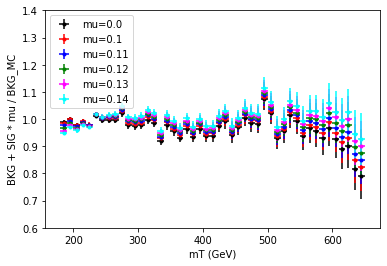

[#1] INFO:NumericIntegration -- RooRealIntegral::init(bsvj_bkgfitua2mod_npars3_rgp_Int[mt|bsvj_bkgfitua2mod_npars3_rpsbp_x_range_bin0]) using numeric integrator RooIntegrator1D to calculate Int(mt)
[#1] INFO:NumericIntegration -- RooRealIntegral::init(bsvj_bkgfitua2mod_npars3_rgp_Int[mt|bsvj_bkgfitua2mod_npars3_rpsbp_x_range_bin1]) using numeric integrator RooIntegrator1D to calculate Int(mt)
[#1] INFO:NumericIntegration -- RooRealIntegral::init(bsvj_bkgfitua2mod_npars3_rgp_Int[mt|bsvj_bkgfitua2mod_npars3_rpsbp_x_range_bin2]) using numeric integrator RooIntegrator1D to calculate Int(mt)
[#1] INFO:NumericIntegration -- RooRealIntegral::init(bsvj_bkgfitua2mod_npars3_rgp_Int[mt|bsvj_bkgfitua2mod_npars3_rpsbp_x_range_bin3]) using numeric integrator RooIntegrator1D to calculate Int(mt)
[#1] INFO:NumericIntegration -- RooRealIntegral::init(bsvj_bkgfitua2mod_npars3_rgp_Int[mt|bsvj_bkgfitua2mod_npars3_rpsbp_x_range_bin4]) using numeric integrator RooIntegrator1D to calculate Int(mt)
[#1] INFO:

Warning in <TCanvas::Constructor>: Deleting canvas with same name: canv
Info in matrix forced pos-def by adding to diagonal : padd = 0.00642884
Info: MnHesse: matrix was forced pos. def. 
Info in Minuit2Minimizer::Minimize : Covar was made pos def
Info in Minuit2Minimizer::Hesse : Hesse is valid - matrix is accurate
Info in matrix forced pos-def by adding to diagonal : padd = 0.00642896
Info: MnHesse: matrix was forced pos. def. 
Info in Minuit2Minimizer::Minimize : Covar was made pos def
Info in Minuit2Minimizer::Hesse : Hesse is valid - matrix is accurate
Info in matrix forced pos-def by adding to diagonal : padd = 0.00642691
Info: MnHesse: matrix was forced pos. def. 
Info in Minuit2Minimizer::Minimize : Covar was made pos def
Info in Minuit2Minimizer::Hesse : Hesse is valid - matrix is accurate
Info in matrix forced pos-def by adding to diagonal : padd = 0.00642346
Info: MnHesse: matrix was forced pos. def. 
Info in Minuit2Minimizer::Minimize : Covar was made pos def
Info in Minuit

In [7]:
# postfit 
ws_sc.loadSnapshot('MultiDimFit')
mu_postfit = ws_sc.var('r').getVal()
bkg_ss = ws_sc.pdf('shapeBkg_roomultipdf_bsvj')
sig_ss = ws_sc.pdf('shapeSig_bsvj_sig_morph')



frame1 = mt.frame()
canv = rt.TCanvas("canv", "canv", 800, 600)
legend = rt.TLegend(0.1, 0.1, 0.55, 0.55)
pdf = ws_sc.pdf("bsvj_bkgfitua2mod_npars3_rgp")

ybkg_ss_plain = bsvj.pdf_values(bkg_ss, mt_bin_centers)
bkg_norm_ss = ws_sc.function('n_exp_final_binbsvj_proc_roomultipdf').getVal()
ybkg_ss_plain *= bkg_norm_ss

## to print the results to a txt file; it didn't work
##import sys
##from io import StringIO 
colors = {0.00:rt.kBlack,0.10:rt.kRed, 0.11:rt.kBlue, 0.12:rt.kGreen, 0.13:rt.kMagenta, 0.14:rt.kCyan}



ybkg_ss={}
ysig_ss={}
y_sb={}
bkg_norm_ss={}
sig_norm_ss={}
par_dict_roo={}
h_bkgscan={}

for i in colors.keys():
    # get bkg & signal values in array format
    ws_sc.var('r').setVal(i)
    ybkg_ss[i] = bsvj.pdf_values(bkg_ss, mt_bin_centers)
    bkg_norm_ss[i] = ws_sc.function('n_exp_final_binbsvj_proc_roomultipdf').getVal()
    ybkg_ss[i] *= bkg_norm_ss[i]
    
    ysig_ss[i] = bsvj.pdf_values(sig_ss, mt_bin_centers)
    sig_norm_ss[i] = ws_sc.function('n_exp_final_binbsvj_proc_sig').getVal()
    ysig_ss[i] *= sig_norm_ss[i]
    y_sb[i] = ybkg_ss[i] + ysig_ss[i]
    
    # transform array to histograms
    h_bkgscan[i] = rt.TH1F("h_bkgscan", "BKG + "+str(i)+" * SIG", 47, 180, 650)
    array2hist(y_sb[i],h_bkgscan[i])

    
    # transform histogram to roodatahist and plot it    
    data_bkgscan = rt.RooDataHist("bkgscan", "dataset with mT", 
                                  rt.RooArgList(mt),  
                                  rt.RooFit.Import(h_bkgscan[i], True))
    data_bkgscan.plotOn(
       frame1,
       #rt.RooFit.DataError(rt.RooAbsData.SumW2),
       rt.RooFit.DataError(rt.RooAbsData.Poisson),
       rt.RooFit.MarkerColor(colors[i]),
       rt.RooFit.Name(f"data_{i}")
    )
    legend.AddEntry(frame1.findObject(f"data_{i}"), "BKG+"+str(i)+"*SIG", "P")

    print('mu=',i)
    
    # fit roodatahist to the pdf and get the parameters per each signal strength values
    result = pdf.fitTo(
        data_bkgscan,
        rt.RooFit.Save(),
        #rt.RooFit.InitialHesse(True),
        rt.RooFit.DataError(rt.RooAbsData.SumW2),
        #rt.RooFit.DataError(rt.RooAbsData.Poisson),
        rt.RooFit.Minimizer("Minuit2"),
    )
    # Get the list of floating parameters after the fit
    params = result.floatParsFinal()
    # Loop over the parameters and print their names and values
    pars=[]
    for p in range(params.getSize()):
        param = params.at(p)
        print(f"    {param.GetName()} = {param.getVal()} +/- {param.getError()}")
        pars.append(param.getVal())
    par_dict_roo[i] = pars
    
    
    # normalize the pdf and plotOn 
    norm = data_bkgscan.sumEntries()
    normalization = rt.RooFit.Normalization(norm, rt.RooAbsReal.NumEvent)
    pdf.plotOn(
       frame1,
       normalization,
       rt.RooFit.LineColor(colors[i]),
       rt.RooFit.Name(f"data_{i}")
    )
    legend.AddEntry(frame1.findObject(f"data_{i}"), "pdf, mu="+str(i), "L")

frame1.Draw("same")
legend.SetTextSize(0.035)
legend.Draw()
canv.SetLogy()
canv.SaveAs('checks/test4.png')

print('*'*10, ' done')

data = ws_sc.data('data_obs')
y_data = bsvj.roodataset_values(data)[1]

colors = {0.00:'black',0.1:'red', 0.11:'blue', 0.12:'green', 0.13:'magenta', 0.14:'cyan'}
for k in y_sb.keys():
    ratio = y_sb[k] / y_data
    y1_err = np.sqrt(y_sb[k])
    y2_err = np.sqrt(y_data)
    # Error propagation for division
    err_bkgmc = ratio * np.sqrt((y1_err / y_sb[k])**2 + (y2_err / ybkg_ss_plain)**2)
    mt_bin_widths = mt_binning[1:] - mt_binning[:-1]
    plt.errorbar(mt_bin_centers,ratio, xerr=.5*mt_bin_widths,yerr=err_bkgmc,fmt='.',label='mu='+str(k),color=colors[k])

plt.legend(loc='upper left')
plt.xlabel('mT (GeV)')
plt.ylabel('BKG + SIG * mu / BKG_MC')
plt.ylim(0.6,1.4)
#plt.savefig('checks/test6.png')

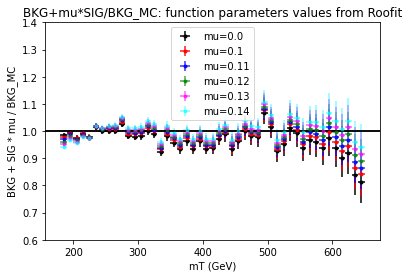

[#1] INFO:Eval -- RooRealVar::setRange(mt) new range named '396ff13e-c577-4acf-a7fc-9395b395cce0_rpsbp_x_range_bin0' created with bounds [180,190]
[#1] INFO:Eval -- RooRealVar::setRange(mt) new range named '396ff13e-c577-4acf-a7fc-9395b395cce0_rpsbp_x_range_bin1' created with bounds [190,200]
[#1] INFO:Eval -- RooRealVar::setRange(mt) new range named '396ff13e-c577-4acf-a7fc-9395b395cce0_rpsbp_x_range_bin2' created with bounds [200,210]
[#1] INFO:Eval -- RooRealVar::setRange(mt) new range named '396ff13e-c577-4acf-a7fc-9395b395cce0_rpsbp_x_range_bin3' created with bounds [210,220]
[#1] INFO:Eval -- RooRealVar::setRange(mt) new range named '396ff13e-c577-4acf-a7fc-9395b395cce0_rpsbp_x_range_bin4' created with bounds [220,230]
[#1] INFO:Eval -- RooRealVar::setRange(mt) new range named '396ff13e-c577-4acf-a7fc-9395b395cce0_rpsbp_x_range_bin5' created with bounds [230,240]
[#1] INFO:Eval -- RooRealVar::setRange(mt) new range named '396ff13e-c577-4acf-a7fc-9395b395cce0_rpsbp_x_range_bin6' c

In [8]:
# evaluate scipy values

def eval_expression(expression, pars):
    """
    Evaluates a ROOT TFormula expression in python.
    Only a limited amount of keywords are implemented (pow, log, sqrt, exp).
    """
    # Load keywords in local scope
    from numpy import log, sqrt, exp
    def pow(base, exponent):
        return base ** exponent
    # Python variables can't start with '@'; replace with some keyword
    expression = expression.replace('@', 'par')
    # Plug parameters in local scope
    par_dict = {i : p for i, p in pars.items()}
    par_dict['par0'] = mt_bin_centers
    
    locals().update(par_dict)
    try:
        return eval(expression)
    except NameError:
        logger.error(
            'Missing variables for expression:\n{0}\nAvailable parameters: {1}'
            .format(expression, list(par_dict.keys()))
            )
        raise
        

        
# plotting BKG+SIG*mu / BKG_MC with  roofit
colors = {0.00:'black',0.1:'red', 0.11:'blue', 0.12:'green', 0.13:'magenta', 0.14:'cyan'}
a = 1
n=0
x=bsvj.pdf_factory("ua2mod", 3, mt, bkg_th1=h_bkgscan[0.0], mt_scale='1000')
expression = x.expression
roofit_dict={}
y_pdfroo={}
for l, p in par_dict_roo.items():
    hist = bsvj.th1_to_hist(h_bkgscan[l])
    roofit_dict[l] = {'par'+str(i+1) : p for i, p in enumerate(p)}
    y_pdfroo[l] = eval_expression(expression, roofit_dict[l])
    y_pdfroo[l] = (y_pdfroo[l] / y_pdfroo[l].sum()) * hist.vals.sum()

    ratio = y_pdfroo[l] / y_data
    y1_err = np.sqrt(y_pdfroo[l])
    y2_err = np.sqrt(y_data)
    
    # Error propagation for division
    err_bkgmc = ratio * np.sqrt((y1_err / y_pdfroo[l])**2 + (y2_err / y_data)**2)
    mt_bin_widths = mt_binning[1:] - mt_binning[:-1]
    
    plt.errorbar(mt_bin_centers,ratio, xerr=.5*mt_bin_widths,yerr=err_bkgmc,fmt='.',
                 label='mu='+str(l),color=colors[l],alpha=a-n/10)
    n+=1
    
plt.legend()
plt.xlabel('mT (GeV)')
plt.ylabel('BKG + SIG * mu / BKG_MC')
plt.ylim(0.6,1.4)
plt.axhline(y=1,color='black')
plt.title('BKG+mu*SIG/BKG_MC: function parameters values from Roofit')
plt.axhline(y=1,color='black')

INFO:2024-12-06 14:29:07:boosted_fits:839 Robust scipy fit of expression exp(@1*@0/1000 + @2*pow(@0/1000,2) + @3*pow(@0/1000,3)) to Name: h_bkgscan Title: BKG + 0.0 * SIG NbinsX: 47
INFO:2024-12-06 14:29:07:boosted_fits:813 Fitting exp(@1*@0/1000 + @2*pow(@0/1000,2) + @3*pow(@0/1000,3)) with 3 parameters
INFO:2024-12-06 14:29:07:boosted_fits:813 Fitting exp(@1*@0/1000 + @2*pow(@0/1000,2) + @3*pow(@0/1000,3)) with 3 parameters
INFO:2024-12-06 14:29:07:boosted_fits:870 Converged with simple fitting strategy, result:
    expression: 'exp(@1*@0/1000 + @2*pow(@0/1000,2) + @3*pow(@0/1000,3))'
 final_simplex: (array([[-16.16052444,  17.55025678, -17.21556862],
       [-16.16052464,  17.55025739, -17.2155692 ],
       [-16.16052462,  17.5502573 , -17.2155691 ],
       [-16.16052442,  17.55025674, -17.21556863]]), array([9.42873741e-07, 9.42873793e-07, 9.42873797e-07, 9.42873841e-07]))
           fun: 9.428737407750406e-07
          hash: '8b5bf389d832190dba94b3eceda55da5f4ce8385d1abde036b91dc5

0.0 373906.9778289795
0.1 375699.9524383545


INFO:2024-12-06 14:29:07:boosted_fits:870 Converged with simple fitting strategy, result:
    expression: 'exp(@1*@0/1000 + @2*pow(@0/1000,2) + @3*pow(@0/1000,3))'
 final_simplex: (array([[-14.28561879,  12.73163264, -13.17857965],
       [-14.28561853,  12.73163194, -13.17857909],
       [-14.28561891,  12.73163298, -13.17857995],
       [-14.28561871,  12.73163231, -13.17857929]]), array([0.08689185, 0.08689185, 0.08689185, 0.08689185]))
           fun: 0.08689185491865749
          hash: '87cfa5bae4d858b4492f3095a9093cafa8401b8d421bc2da7ef4b0fd16600b03'
       message: 'Optimization terminated successfully.'
          nfev: 171
           nit: 98
        status: 0
       success: True
             x: array([-14.28561879,  12.73163264, -13.17857965])
        x_init: array([-14.28561288,  12.73161535, -13.17856449])
INFO:2024-12-06 14:29:07:boosted_fits:839 Robust scipy fit of expression exp(@1*@0/1000 + @2*pow(@0/1000,2) + @3*pow(@0/1000,3)) to Name: h_bkgscan Title: BKG + 0.12 * SIG

0.11 375879.24324035645
0.12 376058.5388946533


INFO:2024-12-06 14:29:08:boosted_fits:870 Converged with simple fitting strategy, result:
    expression: 'exp(@1*@0/1000 + @2*pow(@0/1000,2) + @3*pow(@0/1000,3))'
 final_simplex: (array([[-12.57504657,   8.4501528 ,  -9.64400706],
       [-12.57504635,   8.45015215,  -9.64400648],
       [-12.57504668,   8.45015297,  -9.64400711],
       [-12.57504638,   8.45015218,  -9.64400643]]), array([0.12019246, 0.12019246, 0.12019246, 0.12019246]))
           fun: 0.12019245991772763
          hash: '502091cd4bd3dac7b37fdee9fba47ee8ad0b22c1447ee0e06b8352ceb77a160b'
       message: 'Optimization terminated successfully.'
          nfev: 176
           nit: 107
        status: 0
       success: True
             x: array([-12.57504657,   8.4501528 ,  -9.64400706])
        x_init: array([-12.57504668,   8.45015297,  -9.64400711])
INFO:2024-12-06 14:29:08:boosted_fits:839 Robust scipy fit of expression exp(@1*@0/1000 + @2*pow(@0/1000,2) + @3*pow(@0/1000,3)) to Name: h_bkgscan Title: BKG + 0.14 * SI

0.13 376237.83267211914
0.14 376417.1307983397


Text(0.5, 1.0, 'BKG+mu*SIG/BKG_MC: function parameters values from scipy')

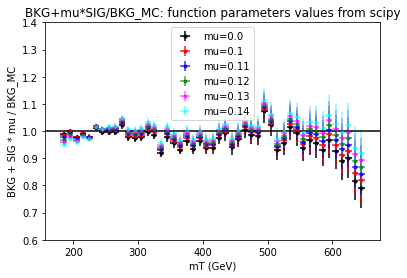

In [9]:
# plot BKG+SIG*mu / BKG_MC with scipyfit

res_scipy = {}
scipy_dict = {}
n=0
y_pdfscipy = {}
for l in h_bkgscan.keys():
    
    res_scipy[l] = bsvj.fit_scipy_robust(x.expression, h_bkgscan[l], cache=None)
    scipy_dict[l] = {'par'+str(i+1) : p for i, p in enumerate(res_scipy[l].x)}
    hist = bsvj.th1_to_hist(h_bkgscan[l])
    
    y_pdfscipy[l] = eval_expression(expression, scipy_dict[l])
    y_pdfscipy[l] = (y_pdfscipy[l] / y_pdfscipy[l].sum()) * hist.vals.sum()

    ratio = y_pdfscipy[l] / y_data
    print(l, y_pdfscipy[l].sum())
    y1_err = np.sqrt(y_pdfscipy[l])
    y2_err = np.sqrt(y_data)
    
    # Error propagation for division
    err_bkgmc = ratio * np.sqrt((y1_err / y_pdfscipy[l])**2 + (y2_err / y_data)**2)
    mt_bin_widths = mt_binning[1:] - mt_binning[:-1]
    
    plt.errorbar(mt_bin_centers,ratio, xerr=.5*mt_bin_widths,yerr=err_bkgmc,fmt='.',
                 label='mu='+str(l),color=colors[l],alpha=a-n/10)
    n+=1
    
plt.legend()
plt.xlabel('mT (GeV)')
plt.ylabel('BKG + SIG * mu / BKG_MC')
plt.ylim(0.6,1.4)
plt.axhline(y=1,color='black')
plt.title('BKG+mu*SIG/BKG_MC: function parameters values from scipy')

In [10]:
# plot scipy only, roofit only, and bkg mc
for l in y_pdfroo.keys():
    plt.plot(mt_bin_centers, y_pdfroo[l], 'P', label='mu='+str(l)+', Roofit')
    plt.plot(mt_bin_centers,y_pdfscipy[l], '*', label='mu='+str(l)+', Scipy')
    plt.plot(mt_bin_centers, y_data, '.',label='BKG MC', color='black')
    plt.legend()
    plt.xlabel('mT (GeV)')
    plt.ylabel('A.U.')
    plt.title('Roofit, Scipy, and BKG MC')
    plt.yscale('log')
    plt.savefig('checks/roofitscipy_mu-'+str(l)+'.png')
    plt.close()

In [11]:
# bkg mc 
i=100

h_bkgscan[i] = rt.TH1F("h_bkgscan", "BKG + "+str(i)+" * SIG", 47, 180, 650)
array2hist(y_data,h_bkgscan[i])
x=bsvj.pdf_factory("ua2mod", 3, mt, bkg_th1=h_bkgscan[i], mt_scale='1000')
res_bf = bsvj.fit(x, th1=None, cache=None)

INFO:2024-12-06 14:29:28:boosted_fits:839 Robust scipy fit of expression exp(@1*@0/1000 + @2*pow(@0/1000,2) + @3*pow(@0/1000,3)) to Name: h_bkgscan Title: BKG + 100 * SIG NbinsX: 47
INFO:2024-12-06 14:29:28:boosted_fits:813 Fitting exp(@1*@0/1000 + @2*pow(@0/1000,2) + @3*pow(@0/1000,3)) with 3 parameters
INFO:2024-12-06 14:29:28:boosted_fits:813 Fitting exp(@1*@0/1000 + @2*pow(@0/1000,2) + @3*pow(@0/1000,3)) with 3 parameters
INFO:2024-12-06 14:29:28:boosted_fits:870 Converged with simple fitting strategy, result:
    expression: 'exp(@1*@0/1000 + @2*pow(@0/1000,2) + @3*pow(@0/1000,3))'
 final_simplex: (array([[-16.02168951,  17.55121958, -17.22332556],
       [-16.02168918,  17.55121871, -17.22332485],
       [-16.02168934,  17.55121921, -17.22332534],
       [-16.02168924,  17.55121885, -17.22332492]]), array([171.44807375, 171.44807375, 171.44807375, 171.44807375]))
           fun: 171.44807375078588
          hash: '24919a8e817c5159c6b5a23f8085b1e47a80bb04136f29214d9be0af505222fe'


[#1] INFO:Eval -- RooRealVar::setRange(mt) new range named '0910a1a6-4014-4ce9-bb31-6ef8fadb9a38_rpsbp_x_range_bin0' created with bounds [180,190]
[#1] INFO:Eval -- RooRealVar::setRange(mt) new range named '0910a1a6-4014-4ce9-bb31-6ef8fadb9a38_rpsbp_x_range_bin1' created with bounds [190,200]
[#1] INFO:Eval -- RooRealVar::setRange(mt) new range named '0910a1a6-4014-4ce9-bb31-6ef8fadb9a38_rpsbp_x_range_bin2' created with bounds [200,210]
[#1] INFO:Eval -- RooRealVar::setRange(mt) new range named '0910a1a6-4014-4ce9-bb31-6ef8fadb9a38_rpsbp_x_range_bin3' created with bounds [210,220]
[#1] INFO:Eval -- RooRealVar::setRange(mt) new range named '0910a1a6-4014-4ce9-bb31-6ef8fadb9a38_rpsbp_x_range_bin4' created with bounds [220,230]
[#1] INFO:Eval -- RooRealVar::setRange(mt) new range named '0910a1a6-4014-4ce9-bb31-6ef8fadb9a38_rpsbp_x_range_bin5' created with bounds [230,240]
[#1] INFO:Eval -- RooRealVar::setRange(mt) new range named '0910a1a6-4014-4ce9-bb31-6ef8fadb9a38_rpsbp_x_range_bin6' c

In [29]:
# variations of mu values

res_bf={}
parvals_bf={}
for i in h_bkgscan.keys():
    if i>1: continue
    h_bkgscan[i] = rt.TH1F("h_bkgscan", "BKG + "+str(i)+" * SIG", 47, 180, 650)
    array2hist(y_sb[i],h_bkgscan[i])
    x=bsvj.pdf_factory("ua2mod", 3, mt, bkg_th1=h_bkgscan[i], mt_scale='1000')
    res_bf[i] = bsvj.fit(x, th1=None, cache=None)
    params = res_bf[i].floatParsFinal()
    # Loop over the parameters and print their names and values
    pars=[]
    for p in range(params.getSize()):
        param = params.at(p)
        #print(f"    {param.GetName()} = {param.getVal()} +/- {param.getError()}")
        pars.append(param.getVal())
        parvals_bf[i]=pars

INFO:2024-12-06 14:35:37:boosted_fits:839 Robust scipy fit of expression exp(@1*@0/1000 + @2*pow(@0/1000,2) + @3*pow(@0/1000,3)) to Name: h_bkgscan Title: BKG + 0.0 * SIG NbinsX: 47
INFO:2024-12-06 14:35:37:boosted_fits:813 Fitting exp(@1*@0/1000 + @2*pow(@0/1000,2) + @3*pow(@0/1000,3)) with 3 parameters
INFO:2024-12-06 14:35:37:boosted_fits:813 Fitting exp(@1*@0/1000 + @2*pow(@0/1000,2) + @3*pow(@0/1000,3)) with 3 parameters
INFO:2024-12-06 14:35:37:boosted_fits:870 Converged with simple fitting strategy, result:
    expression: 'exp(@1*@0/1000 + @2*pow(@0/1000,2) + @3*pow(@0/1000,3))'
 final_simplex: (array([[-16.16052444,  17.55025678, -17.21556862],
       [-16.16052464,  17.55025739, -17.2155692 ],
       [-16.16052462,  17.5502573 , -17.2155691 ],
       [-16.16052442,  17.55025674, -17.21556863]]), array([9.42873741e-07, 9.42873793e-07, 9.42873797e-07, 9.42873841e-07]))
           fun: 9.428737407750406e-07
          hash: '8b5bf389d832190dba94b3eceda55da5f4ce8385d1abde036b91dc5

INFO:2024-12-06 14:35:37:boosted_fits:724 Fitting pdf <RooParametricShapeBinPdf "a5797000-be5f-43be-8e3c-479028c84c1c"
  pdf_type   = ua2mod
  n_pars     = 3
  expression = "exp(@1*@0/1000 + @2*pow(@0/1000,2) + @3*pow(@0/1000,3))"
  pdf        = "a5797000-be5f-43be-8e3c-479028c84c1c_rpsbp"
  mt         = "mt"
  th1        = "h_bkgscan"
  rgp        = "a5797000-be5f-43be-8e3c-479028c84c1c_rgp"
  parameters = 
    "a5797000-be5f-43be-8e3c-479028c84c1c_p1"
    "a5797000-be5f-43be-8e3c-479028c84c1c_p2"
    "a5797000-be5f-43be-8e3c-479028c84c1c_p3"
  > to data_hist Name: 0feb6dea-4a31-4bda-b10f-0b562e938865 Title:  with RooFit
INFO:2024-12-06 14:35:37:boosted_fits:766 Setting a5797000-be5f-43be-8e3c-479028c84c1c_p1 (p1) value to -13.409928441743963, range is -100.0 to 100.0
INFO:2024-12-06 14:35:37:boosted_fits:766 Setting a5797000-be5f-43be-8e3c-479028c84c1c_p2 (p2) value to 10.524371462849238, range is -100.0 to 100.0
INFO:2024-12-06 14:35:37:boosted_fits:766 Setting a5797000-be5f-43be-8e

[#1] INFO:Eval -- RooRealVar::setRange(mt) new range named '8ad2825c-603f-4269-99cf-b6d58d674300_rpsbp_x_range_bin0' created with bounds [180,190]
[#1] INFO:Eval -- RooRealVar::setRange(mt) new range named '8ad2825c-603f-4269-99cf-b6d58d674300_rpsbp_x_range_bin1' created with bounds [190,200]
[#1] INFO:Eval -- RooRealVar::setRange(mt) new range named '8ad2825c-603f-4269-99cf-b6d58d674300_rpsbp_x_range_bin2' created with bounds [200,210]
[#1] INFO:Eval -- RooRealVar::setRange(mt) new range named '8ad2825c-603f-4269-99cf-b6d58d674300_rpsbp_x_range_bin3' created with bounds [210,220]
[#1] INFO:Eval -- RooRealVar::setRange(mt) new range named '8ad2825c-603f-4269-99cf-b6d58d674300_rpsbp_x_range_bin4' created with bounds [220,230]
[#1] INFO:Eval -- RooRealVar::setRange(mt) new range named '8ad2825c-603f-4269-99cf-b6d58d674300_rpsbp_x_range_bin5' created with bounds [230,240]
[#1] INFO:Eval -- RooRealVar::setRange(mt) new range named '8ad2825c-603f-4269-99cf-b6d58d674300_rpsbp_x_range_bin6' c

In [31]:
# check chi2 minimization for individual values

for i in h_bkgscan.keys():
    if i>1: continue
    chi = bsvj.build_chi2(x.expression, h_bkgscan[i])
    chi_res = minimize(chi, parvals_bf[i])
    print('mu=', i, 'convergance=', chi_res.success, ', pars:', chi_res.x)

mu= 0.0 convergance= True , pars: [-16.16052486  17.55025782 -17.21556941]
mu= 0.1 convergance= True , pars: [-15.20244459  15.07328131 -15.13371456]
mu= 0.11 convergance= True , pars: [-14.28561866  12.7316321  -13.17857904]
mu= 0.12 convergance= True , pars: [-13.4099286   10.52437181 -11.34907498]
mu= 0.13 convergance= True , pars: [-12.57504678   8.45015321  -9.64400729]
mu= 0.14 convergance= True , pars: [-11.77989266   6.50521923  -8.05934575]


In [71]:
import itertools, re, logging, os, os.path as osp, copy, subprocess, json
from numpy import log, sqrt, exp

def eval_expression(expression, pars):
    """
    Evaluates a ROOT TFormula expression in python.
    Only a limited amount of keywords are implemented (pow, log, sqrt, exp).
    """
    # Load keywords in local scope
    from numpy import log, sqrt, exp
    def pow(base, exponent):
        return base ** exponent
    # Python variables can't start with '@'; replace with some keyword
    expression = expression.replace('@', 'par')
    # Plug parameters in local scope
    par_dict = {i : p for i, p in pars.items()}
    par_dict['par0'] = mt_bin_centers
    
    locals().update(par_dict)
    try:
        return eval(expression)
    except NameError:
        logger.error(
            'Missing variables for expression:\n{0}\nAvailable parameters: {1}'
            .format(expression, list(par_dict.keys()))
            )
        raise

mt = ws_sc.var('mt')
x=bsvj.pdf_factory("ua2mod", 3, mt, bkg_th1=h_bkgscan[0.0], mt_scale='1000')

expression = x.expression.replace('@', 'par')

rss  = bsvj.build_rss(x.expression,h_bkgscan[0])
chi2 = bsvj.build_chi2(x.expression, h_bkgscan[0])
chi_res = minimize(chi2, [1.,1.,1.])
rss_res = minimize(rss,[1.,1.,1.])

par_dict_rss = {'par'+str(i+1): rss_res.x[i] for i in range(len(rss_res.x))}
par_dict_ch2 = {'par'+str(i+1): chi_res.x[i] for i in range(len(chi_res.x))}
par_dict_rof = {'par'+str(i+1): par_dict_roo[0.14][i] for i in range(len(par_dict_roo[0.14]))}
par_dict_sci = {'par'+str(i+1): optimized_params[i] for i in range(len(optimized_params))}

paras = {'rss':par_dict_rss, 'chi2':par_dict_ch2, 'roofit':par_dict_rof,'scipy':par_dict_sci}
hist = bsvj.th1_to_hist(h_bkgscan[0.0])

for i, p in paras.items():
    y_pdf = eval_expression(expression,p)
    y_pdf = (y_pdf / y_pdf.sum()) * hist.vals.sum()
    #print(y_pdf)
    plt.plot(mt_bin_centers,(y_pdf-y_data)/y_data, 'o',label=i)
plt.axhline(y=0)
plt.legend()




NameError: name 'optimized_params' is not defined

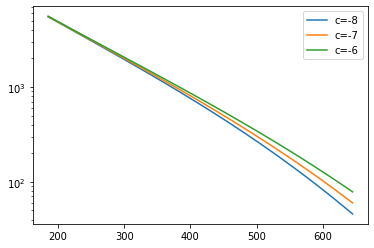

In [125]:
for c in range(-8,-5):
    plt.plot(mt_bin_centers, fit_function(mt_bin_centers,-10,5,c),label= 'c='+str(c))
plt.legend()
plt.yscale('log')

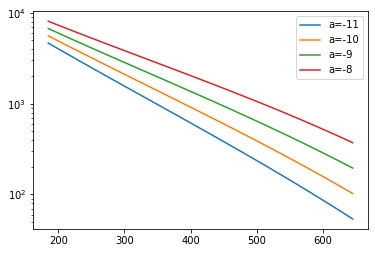

In [126]:
for a in range(-11,-7):
    plt.plot(mt_bin_centers, fit_function(mt_bin_centers,a,5,-5),label= 'a='+str(a))
plt.legend()
plt.yscale('log')


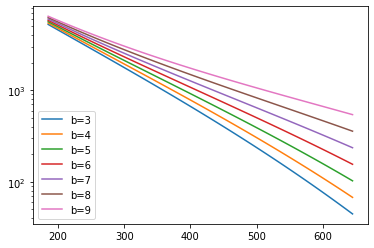

In [128]:
def fit_function(x,a,b,c):
    return np.exp(a*x/1000 + b*pow(x/1000,2) + c*pow(x/1000,3))*31000

for b in range(3,10):
    plt.plot(mt_bin_centers, fit_function(mt_bin_centers,-10,b,-5),label= 'b='+str(b))
plt.legend()
plt.yscale('log')

In [ ]:
def chi2_stat(observed, expected):
     return np.sum((observed - expected)**2 / expected)
    
def rss_stat(observed, expected):
     return np.sum((observed - expected)**2)  
    
plt.plot(mt_bin_centers, y_data,'o',label='bkg MC', color='black')
colors = {0.0:'red', 0.1:'green',0.11:'blue',0.12:'orange', 0.13:'magenta', 0.14:'cyan'}
for l, p in par_dict_roo.items(): 
    ndf = len(mt_bin_centers) - 3
    plt.plot(mt_bin_centers, y_sb[l],'*',label='roofit, mu='+str(l), color=colors[l])
    plt.plot(mt_bin_centers, y_pdf[l],'P', label='scipyfit, mu='+str(l), color=colors[l])
    
    print('mu='+str(l)+', chi2 scipy=', np.round(chi2_stat(y_data,y_pdf[l])/ndf,2), ', roofit=',
          np.round(chi2_stat(y_data,y_sb[l])/ndf,2),'; rss scipy=',np.round(rss_stat(y_data,y_pdf[l])/ndf,2),
          ',  roofit=',np.round(rss_stat(y_data,y_sb[l])/ndf,2))
plt.legend()
plt.xlabel('mT (GeV)')
plt.ylabel('A.U.')


In [715]:
def eval_expression(expression, pars):
    """
    Evaluates a ROOT TFormula expression in python.
    Only a limited amount of keywords are implemented (pow, log, sqrt, exp).
    """
    # Load keywords in local scope
    from numpy import log, sqrt, exp
    def pow(base, exponent):
        return base ** exponent
    # Python variables can't start with '@'; replace with some keyword
    expression = expression.replace('@', 'PARAMETER')
    # Plug parameters in local scope
    #par_dict = {'par'+str(i) : p.getVal() for i, p in enumerate(pars) if i>0}
    par_dict = {'par'+str(i) : p for i, p in enumerate(pars) if i>0}
    par_dict['par0'] = mt_bin_centers
    locals().update(par_dict)
    # logger.warning('Evaluating expr:\n%s\nwith parameters:\n%s', expression, par_dict)
    try:
        return eval(expression)
    except NameError:
        logger.error(
            'Missing variables for expression:\n{0}\nAvailable parameters: {1}'
            .format(expression, list(par_dict.keys()))
            )
        raise
#expression = bsvj.add_normalization(x.expression)        
expression = x.expression.replace('@', 'PARAMETER')
#expression = expression.replace('@', 'PARAMETER')
parameters= x.parameters
parameters = list(copy.copy(parameters))
parameters.insert(0, mt_bin_centers)
par_dict = {'PARAMETER'+str(i) : p.getVal() for i, p in enumerate(parameters) if i>0}# else: p.getVal()}
par_dict['PARAMETER0']=mt_bin_centers
y_pdf = eval_expression(expression,parameters)
hist = bsvj.th1_to_hist(h_bkgscan)
y_pdf=(y_pdf/y_pdf.sum()) * hist.vals.sum()
#par_dict['PARAMETER4']=(y_pdf/y_pdf.sum()) * h_bkgscan.vals.sum()
locals().update(par_dict)
par_dict        
print(eval_expression(expression,parameters),y_pdf, hist.vals.sum())

def eval_pdf_python(pdf, parameters, mt_array=None):
    if mt_array is None:
        mt = pdf.parameters[0]
        binning = mt.getBinning()
        mt_array = np.array([ binning.binCenter(i) for i in range(binning.numBins()) ])
    parameters = list(copy.copy(parameters))
    parameters.insert(0, mt_array)
    return eval_expression(pdf.expression, parameters)

eval_pdf_python(x,x.parameters,mt_bin_centers)

[1.25301998 1.27180846 1.29128794 1.31148932 1.33244503 1.35418917
 1.37675754 1.40018781 1.42451959 1.44979458 1.47605668 1.50335214
 1.53172971 1.56124078 1.59193956 1.62388329 1.65713238 1.69175064
 1.72780553 1.76536837 1.80451458 1.84532401 1.88788117 1.9322756
 1.97860218 2.0269615  2.07746027 2.13021172 2.18533607 2.24296102
 2.30322226 2.36626408 2.43223996 2.5013132  2.57365772 2.64945875
 2.72891372 2.81223313 2.89964155 2.99137867 3.08770046 3.18888037
 3.29521075 3.40700421 3.52459531 3.64834221 3.77862854] [37852.44617724 33949.83119794 30480.16956187 27390.5114059
 24635.01428796 22173.91218904 19972.64430896 18001.11738568
 16233.07982005 14645.58961273 13218.56117544 11934.37858951
 10777.56495288  9734.49916326  8793.17289666  7942.98171015
  7174.54516848  6479.55170183  5850.62457539  5281.2059131
  4765.45618818  4298.16698703  3874.68518364  3490.84693963
  3142.92017949  2827.55438775  2541.73674207  2282.75373738
  2048.15757592  1835.7366997   1643.48992852  146

array([1.25301998, 1.27180846, 1.29128794, 1.31148932, 1.33244503,
       1.35418917, 1.37675754, 1.40018781, 1.42451959, 1.44979458,
       1.47605668, 1.50335214, 1.53172971, 1.56124078, 1.59193956,
       1.62388329, 1.65713238, 1.69175064, 1.72780553, 1.76536837,
       1.80451458, 1.84532401, 1.88788117, 1.9322756 , 1.97860218,
       2.0269615 , 2.07746027, 2.13021172, 2.18533607, 2.24296102,
       2.30322226, 2.36626408, 2.43223996, 2.5013132 , 2.57365772,
       2.64945875, 2.72891372, 2.81223313, 2.89964155, 2.99137867,
       3.08770046, 3.18888037, 3.29521075, 3.40700421, 3.52459531,
       3.64834221, 3.77862854])

In [716]:
# postfit pdf fit with scipy instead of roofit
# compare parameters of fit with roofit results

pdf = ws_sc.pdf("bsvj_bkgfitua2mod_npars3_rgp")
mu=0.14
integral = sum(y_sb[mu])

def fit_function(x,a,b,c):
    return np.exp(a*x/1000 + b*pow(x/1000,2) + c*pow(x/1000,3))*integral
     
print(sum(y_sb[mu]))


# get the parameters of the fit
par = curve_fit(fit_function, mt_bin_centers,y_sb[mu])
a,b,c = par[0]

f = fit_function(mt_bin_centers, a, b, c)
(f-y_data)/y_data

def chi2_stat(observed, expected):
     return np.sum((observed - expected)**2 / expected)
    
def chi2_formula(par):
    chi2 = np.sum((y_data - fit_function(mt_bin_centers,par[0],par[1],par[2]))**2 / fit_function(mt_bin_centers,par[0],par[1],par[2]))
    return chi2
 
    
from scipy.optimize import minimize
chi2_1st = chi2_stat(y_sb[mu], f)
result = minimize(chi2_stat, y_data,f)



chi2_2nd = chi2_formula(par[0])#,mt_bin_centers,y_data)
initial_guess = [-11.77989177,   6.50521675,  -8.05934364]
result_2nd = minimize(chi2_formula, initial_guess)#, args=(mt_bin_centers, y_data),method='BFGS')

optimized_params = result_2nd.x
optimized_params

376417.1328630731


array([-14.23627504,  12.44895694, -12.69790913])

In [714]:
# a sanity check that the pdf function is giving an actual value
# for the function

def fit_function(x,a,b,c):
    return np.exp(a*x/1000 + b*pow(x/1000,2) + c*pow(x/1000,3))

a,b,c = [f for f in chi_res.x]

y=fit_function(mt_bin_centers, a, b, c)
y=y/y.sum() * sum(h_bkgscan)

y2=eval_expression(x.expression,par_dict_ch2)
y2=y2/y2.sum() * sum(h_bkgscan)

y2/y


array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [ ]:
# postfit pdf fit with scipy instead of roofit
# compare parameters of fit with roofit results
# the function is defined manually

from scipy.optimize import minimize

pdf = ws_sc.pdf("bsvj_bkgfitua2mod_npars3_rgp")
mu=0.14
integral = sum(y_sb[mu])

def fit_function(x,a,b,c):
    return np.exp(a*x/1000 + b*pow(x/1000,2) + c*pow(x/1000,3))*integral
f = fit_function(mt_bin_centers, a, b, c)
(f-y_data)/y_data     


# get the parameters of the fit
par = curve_fit(fit_function, mt_bin_centers,y_sb[mu])
a,b,c = par[0]

    
def chi2_formula(par):
    chi2 = np.sum((y_data - fit_function(mt_bin_centers,par[0],par[1],par[2]))**2 / fit_function(mt_bin_centers,par[0],par[1],par[2]))
    return chi2
 
chi2 = chi2_formula(par[0])
initial_guess = [-11.77989177,   6.50521675,  -8.05934364]
result = minimize(chi2_formula, initial_guess)

optimized_params = result.x
optimized_params

In [727]:
# some checks on how the scipy fit is working in boosted_fits code


res_bfgs={}
res_neld={}
res_robu={}

for i in h_bkgscan.keys():
    res_bfgs[i] = bsvj.single_fit_scipy(
        x.expression, h_bkgscan[i],
        tol=1e-3, method='BFGS',
        cache=None
        )
    res_neld[i] = bsvj.single_fit_scipy(
        x.expression, h_bkgscan[i],
        init_vals=res_bfgs[i].x,
        tol=1e-6, method='Nelder-Mead',
        cache=None,
        options = options_nm
        )
    res_robu[i] = bsvj.fit_scipy_robust(x.expression, h_bkgscan[i], cache=None)
    
[res_robu[i].x/res_neld[i].x for i in res_bfgs.keys()]

INFO:2024-12-05 13:47:10:boosted_fits:813 Fitting exp(@1*@0/1000 + @2*pow(@0/1000,2) + @3*pow(@0/1000,3)) with 3 parameters
INFO:2024-12-05 13:47:10:boosted_fits:813 Fitting exp(@1*@0/1000 + @2*pow(@0/1000,2) + @3*pow(@0/1000,3)) with 3 parameters
INFO:2024-12-05 13:47:10:boosted_fits:839 Robust scipy fit of expression exp(@1*@0/1000 + @2*pow(@0/1000,2) + @3*pow(@0/1000,3)) to Name: h_bkgscan Title: BKG + 0.0 * SIG NbinsX: 47
INFO:2024-12-05 13:47:10:boosted_fits:813 Fitting exp(@1*@0/1000 + @2*pow(@0/1000,2) + @3*pow(@0/1000,3)) with 3 parameters
INFO:2024-12-05 13:47:10:boosted_fits:813 Fitting exp(@1*@0/1000 + @2*pow(@0/1000,2) + @3*pow(@0/1000,3)) with 3 parameters
INFO:2024-12-05 13:47:10:boosted_fits:870 Converged with simple fitting strategy, result:
    expression: 'exp(@1*@0/1000 + @2*pow(@0/1000,2) + @3*pow(@0/1000,3))'
 final_simplex: (array([[-16.16052444,  17.55025678, -17.21556862],
       [-16.16052464,  17.55025739, -17.2155692 ],
       [-16.16052462,  17.5502573 , -17

INFO:2024-12-05 13:47:11:boosted_fits:813 Fitting exp(@1*@0/1000 + @2*pow(@0/1000,2) + @3*pow(@0/1000,3)) with 3 parameters
INFO:2024-12-05 13:47:11:boosted_fits:813 Fitting exp(@1*@0/1000 + @2*pow(@0/1000,2) + @3*pow(@0/1000,3)) with 3 parameters
INFO:2024-12-05 13:47:11:boosted_fits:870 Converged with simple fitting strategy, result:
    expression: 'exp(@1*@0/1000 + @2*pow(@0/1000,2) + @3*pow(@0/1000,3))'
 final_simplex: (array([[-11.77989177,   6.50521675,  -8.05934364],
       [-11.77989146,   6.50521592,  -8.05934288],
       [-11.77989205,   6.50521771,  -8.05934457],
       [-11.77989206,   6.50521753,  -8.05934422]]), array([0.13854619, 0.13854619, 0.13854619, 0.13854619]))
           fun: 0.13854619175141542
          hash: '601d988f9094e24befcc9f8befdf9e6c841c48a33ce0c99666b5cb19805931d1'
       message: 'Optimization terminated successfully.'
          nfev: 158
           nit: 92
        status: 0
       success: True
             x: array([-11.77989177,   6.50521675,  -8.

[array([1., 1., 1.]),
 array([1., 1., 1.]),
 array([1., 1., 1.]),
 array([1., 1., 1.]),
 array([1., 1., 1.]),
 array([1., 1., 1.])]